### goal-conditioned gridland collection notebook

100%|██████████| 50/50 [00:00<00:00, 51.31it/s]


(140000, 2)
(140000,)
(140000, 2)


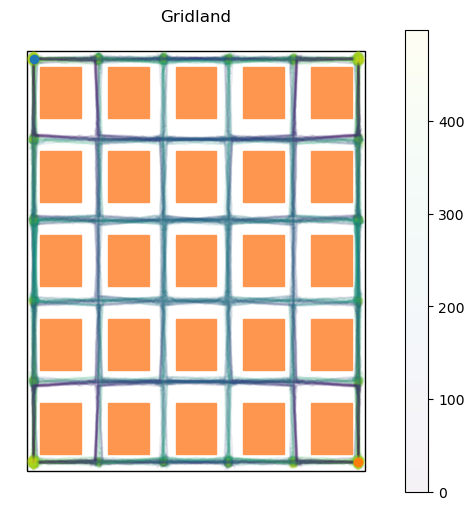

In [45]:
# COLLECTS FOR Start-4 random goal pairs only 

### collects for single S-G pair - from top left to bottom right. 
# randomly varies which direction to go at keypoints
from gridland_environment import GridLand
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


# various parameters
MAX_EP_LENGTH = 500 # should take ~450 steps 
TOTAL_SAMPLES =  25_000# OGBench had 1 million this seems reasonable eh
HOLDOUT_SPLIT = 0.3333
RANDOM_SEED = 42
SIZE = 5
num_goals = 4
keypoint_tolerance = 0.025 # for now set to same as env's goal tolerance who cares
gaussian_scale = 0.025 # random noise during action collection
save_directory = 'gridland_data_new'
generator = np.random.default_rng(seed=RANDOM_SEED)



# creates and resets the environment
env = GridLand(n_size=SIZE,timeout = MAX_EP_LENGTH)
state, info = env.reset(start_idx='T0',goal_idx='B' + str(SIZE))

# gets a list of all border keypoints to work as start/stop states
border_keypoint_list = set()
for x_keypoint in range(len(env.keypoints)):
    for y_keypoint in range(len(env.keypoints)):
        keypoint = tuple((x_keypoint,y_keypoint))
        if 0 in keypoint or SIZE in keypoint:
            border_keypoint_list.add(keypoint)

border_keypoint_start_list = list(border_keypoint_list)
border_keypoint_goal_list = border_keypoint_start_list.copy()

# bottom thing verifies keypoints are in correct place
# print(border_keypoint_list)
#fig, ax = env.get_mpl_plot()
#for keypoint in border_keypoint_list:
  #ax.scatter(env.keypoints[keypoint[0]],env.keypoints[keypoint[1]])

# starts trajectory recording storage
obs_record = []
term_record = []
act_record = []

for i,start_keypoint in enumerate(border_keypoint_start_list):
        generator.shuffle(border_keypoint_goal_list)
        for j in range(num_goals):
            end_keypoint = border_keypoint_goal_list[j]
            
            # initializes start and grabs a random goal
            start_idx = list(start_keypoint)
            goal_idx = list(end_keypoint)
            required_h_trav = end_keypoint[0] - start_keypoint[0]
            required_v_trav = end_keypoint[1] - start_keypoint[1]
            required_trav = np.array([required_h_trav,required_v_trav])
            # initializes keypoint to wayfind to
            keypoint_ind = start_idx.copy()
            # keypoint updating logic
            prefered_index = -1
            if generator.random() > 0.5:
                prefered_index = 0
            else:
                prefered_index = 1
            if required_trav[0] != 0 and required_trav[1] == 0:
                prefered_index = 0
            elif required_trav[0] == 0 and required_trav[1] != 0:
                prefered_index = 1
            keypoint_ind[prefered_index] += np.sign(required_trav[prefered_index])
            required_trav[prefered_index] -= np.sign(required_trav[prefered_index])
            
            keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
            at_keypoint = False
            truncated = False
            state, info = env.reset(start_idx=start_idx,goal_idx=goal_idx)
            while not truncated:
                obs_record.append(state)
                at_keypoint = np.linalg.norm(keypoint-state) <= keypoint_tolerance
                if at_keypoint:
                    # TODO write keypoint updating logic
                    prefered_index = -1
                    if generator.random() > 0.5:
                        prefered_index = 0
                    else:
                        prefered_index = 1
                    if required_trav[0] != 0 and required_trav[1] == 0:
                        prefered_index = 0
                    elif required_trav[0] == 0 and required_trav[1] != 0:
                        prefered_index = 1
                    keypoint_ind[prefered_index] += np.sign(required_trav[prefered_index])
                    required_trav[prefered_index] -= np.sign(required_trav[prefered_index])
                    #print(keypoint_ind)
                    keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
                    #print(keypoint)
                action = keypoint - state
                # adds small gaussian noise 
                action = action + generator.normal(loc=0,scale=gaussian_scale,size=action.shape)
                state, _, terminated, truncated, info = env.step(action)
                # recording
                term_record.append(truncated) # why this? sequence loader uses terminations as signs of traj. demarkation
                act_record.append(action)
action = np.array((1,-1))
generator = np.random.default_rng(seed=RANDOM_SEED)
env = GridLand(n_size=SIZE,timeout = MAX_EP_LENGTH)

for episode in trange(int(TOTAL_SAMPLES/MAX_EP_LENGTH)):
    # sets up storage
    ep_obs_record = []
    ep_term_record = []
    ep_act_record = []
    # initializes keypoint to wayfind to
    keypoint_ind = np.array([0,env.n_size])
    if generator.random() > 0.5:
        keypoint_ind[0] += 1
    else:
        keypoint_ind[1] -= 1
    keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
    at_keypoint = False
    truncated = False
    state, info = env.reset(start_idx='T0',goal_idx='B' + str(SIZE))
    while not truncated:
        ep_obs_record.append(state)
        at_keypoint = np.linalg.norm(keypoint-state) <= keypoint_tolerance
        if at_keypoint:
            if keypoint_ind[0] < env.n_size and keypoint_ind[1] > 0:
                if generator.random() > 0.5 :
                    keypoint_ind[0] += 1
                else:
                    keypoint_ind[1] -= 1
            elif keypoint_ind[0] < env.n_size:
                keypoint_ind[0] += 1
            elif keypoint_ind[1] > 0:
                keypoint_ind[1] -= 1
            keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
        action = keypoint - state
        # adds small gaussian noise 
        action = action + generator.normal(loc=0,scale=gaussian_scale,size=action.shape)
        state, _, terminated, truncated, info = env.step(action)
        # recording
        ep_term_record.append(truncated) # why this? sequence loader uses terminations as signs of traj. demarkation
        ep_act_record.append(action)

    # stores all 4 corner variants
    for corner in ((1,1),(-1,1),(1,-1),(-1,-1)):
        for obs, act, term in zip(ep_obs_record,ep_act_record,ep_term_record):
            obs_record.append(obs * corner)
            act_record.append(act * corner)
            term_record.append(term)
fig, ax = env.get_mpl_plot()
obs_record = np.array(obs_record)
term_record = np.array(term_record)
act_record = np.array(act_record)
print(obs_record.shape)
print(term_record.shape)
print(act_record.shape)
# shows a little bit of visualization
for episode in range(int(len(term_record)//MAX_EP_LENGTH)):
    thingy = ax.scatter(obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,0],
               obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,1],s=1,
               alpha=0.05,
               c=range(len(obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,0])))
fig.colorbar(thingy)
#ax.legend()
save_dict = {'observations':obs_record,'terminals':term_record,'actions':act_record}
np.save(save_directory+'/dataset_n'+str(SIZE) +'_gc'+'.npy',save_dict)

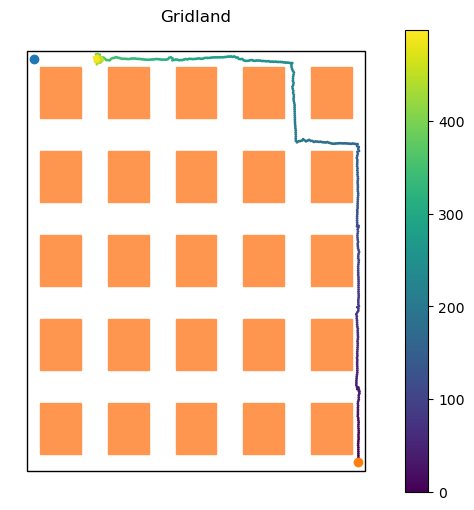

In [44]:
episode = 37
fig, ax = env.get_mpl_plot()
thingy = ax.scatter(obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,0],
            obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,1],s=1,
            alpha=1,
            c=range(len(obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,0])))
fig.colorbar(thingy)


In [21]:
110000/500

220.0

(40000, 2)
(40000,)
(40000, 2)


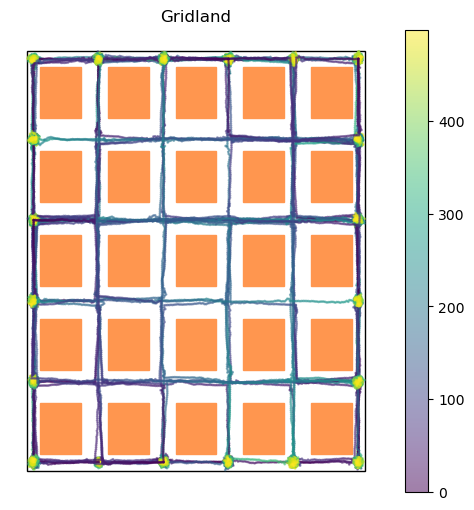

In [ ]:
# COLLECTS FOR Start-4 random goal pairs only 

### collects for single S-G pair - from top left to bottom right. 
# randomly varies which direction to go at keypoints
from gridland_environment import GridLand
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


# various parameters
MAX_EP_LENGTH = 500 # should take ~450 steps 
TOTAL_SAMPLES =  25_000# OGBench had 1 million this seems reasonable eh
HOLDOUT_SPLIT = 0.3333
RANDOM_SEED = 42
SIZE = 5
num_goals = 4
keypoint_tolerance = 0.025 # for now set to same as env's goal tolerance who cares
gaussian_scale = 0.025 # random noise during action collection
save_directory = 'gridland_data_new'
generator = np.random.default_rng(seed=RANDOM_SEED)



# creates and resets the environment
env = GridLand(n_size=SIZE,timeout = MAX_EP_LENGTH)
state, info = env.reset(start_idx='T0',goal_idx='B' + str(SIZE))

# gets a list of all border keypoints to work as start/stop states
border_keypoint_list = set()
for x_keypoint in range(len(env.keypoints)):
    for y_keypoint in range(len(env.keypoints)):
        keypoint = tuple((x_keypoint,y_keypoint))
        if 0 in keypoint or SIZE in keypoint:
            border_keypoint_list.add(keypoint)

border_keypoint_start_list = list(border_keypoint_list)
border_keypoint_goal_list = border_keypoint_start_list.copy()

# bottom thing verifies keypoints are in correct place
# print(border_keypoint_list)
#fig, ax = env.get_mpl_plot()
#for keypoint in border_keypoint_list:
  #ax.scatter(env.keypoints[keypoint[0]],env.keypoints[keypoint[1]])

# starts trajectory recording storage
obs_record = []
term_record = []
act_record = []

for i,start_keypoint in enumerate(border_keypoint_start_list):
        generator.shuffle(border_keypoint_goal_list)
        for j in range(num_goals):
            end_keypoint = border_keypoint_goal_list[j]
            
            # initializes start and grabs a random goal
            start_idx = list(start_keypoint)
            goal_idx = list(end_keypoint)
            required_h_trav = end_keypoint[0] - start_keypoint[0]
            required_v_trav = end_keypoint[1] - start_keypoint[1]
            required_trav = np.array([required_h_trav,required_v_trav])
            # initializes keypoint to wayfind to
            keypoint_ind = start_idx.copy()
            # keypoint updating logic
            prefered_index = -1
            if generator.random() > 0.5:
                prefered_index = 0
            else:
                prefered_index = 1
            if required_trav[0] != 0 and required_trav[1] == 0:
                prefered_index = 0
            elif required_trav[0] == 0 and required_trav[1] != 0:
                prefered_index = 1
            keypoint_ind[prefered_index] += np.sign(required_trav[prefered_index])
            required_trav[prefered_index] -= np.sign(required_trav[prefered_index])
            
            keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
            at_keypoint = False
            truncated = False
            state, info = env.reset(start_idx=start_idx,goal_idx=goal_idx)
            while not truncated:
                obs_record.append(state)
                at_keypoint = np.linalg.norm(keypoint-state) <= keypoint_tolerance
                if at_keypoint:
                    # TODO write keypoint updating logic
                    prefered_index = -1
                    if generator.random() > 0.5:
                        prefered_index = 0
                    else:
                        prefered_index = 1
                    if required_trav[0] != 0 and required_trav[1] == 0:
                        prefered_index = 0
                    elif required_trav[0] == 0 and required_trav[1] != 0:
                        prefered_index = 1
                    keypoint_ind[prefered_index] += np.sign(required_trav[prefered_index])
                    required_trav[prefered_index] -= np.sign(required_trav[prefered_index])
                    #print(keypoint_ind)
                    keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
                    #print(keypoint)
                action = keypoint - state
                # adds small gaussian noise 
                action = action + generator.normal(loc=0,scale=gaussian_scale,size=action.shape)
                state, _, terminated, truncated, info = env.step(action)
                # recording
                term_record.append(truncated) # why this? sequence loader uses terminations as signs of traj. demarkation
                act_record.append(action)
fig, ax = env.get_mpl_plot()
obs_record = np.array(obs_record)
term_record = np.array(term_record)
act_record = np.array(act_record)
print(obs_record.shape)
print(term_record.shape)
print(act_record.shape)
# shows a little bit of visualization
for episode in range(int(len(term_record)//MAX_EP_LENGTH)):
    thingy = ax.scatter(obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,0],
               obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,1],s=1,
               alpha=0.5,
               c=range(len(obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,0])))
fig.colorbar(thingy)
#ax.legend()
save_dict = {'observations':obs_record,'terminals':term_record,'actions':act_record}
np.save(save_directory+'/dataset_n'+str(SIZE) +'_gc'+'.npy',save_dict)

In [1]:
# prints the S-G pairs from above

### collects for single S-G pair - from top left to bottom right. 
# randomly varies which direction to go at keypoints
from gridland_environment import GridLand
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


# COLLECTS FOR Start-4 random goal pairs only 

### collects for single S-G pair - from top left to bottom right. 
# randomly varies which direction to go at keypoints
from gridland_environment import GridLand
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


# various parameters
MAX_EP_LENGTH = 500 # should take ~450 steps 
TOTAL_SAMPLES =  25_000# OGBench had 1 million this seems reasonable eh
HOLDOUT_SPLIT = 0.3333
RANDOM_SEED = 42
SIZE = 5
num_goals = 4
keypoint_tolerance = 0.025 # for now set to same as env's goal tolerance who cares
gaussian_scale = 0.025 # random noise during action collection
save_directory = 'gridland_data_new'
generator = np.random.default_rng(seed=RANDOM_SEED)



# creates and resets the environment
env = GridLand(n_size=SIZE,timeout = MAX_EP_LENGTH)
state, info = env.reset(start_idx='T0',goal_idx='B' + str(SIZE))

# gets a list of all border keypoints to work as start/stop states
border_keypoint_list = set()
for x_keypoint in range(len(env.keypoints)):
    for y_keypoint in range(len(env.keypoints)):
        keypoint = tuple((x_keypoint,y_keypoint))
        if 0 in keypoint or SIZE in keypoint:
            border_keypoint_list.add(keypoint)

border_keypoint_start_list = list(border_keypoint_list)
border_keypoint_goal_list = border_keypoint_start_list.copy()

# bottom thing verifies keypoints are in correct place
# print(border_keypoint_list)
#fig, ax = env.get_mpl_plot()
#for keypoint in border_keypoint_list:
  #ax.scatter(env.keypoints[keypoint[0]],env.keypoints[keypoint[1]])

# starts trajectory recording storage
obs_record = []
term_record = []
act_record = []

for i,start_keypoint in enumerate(border_keypoint_start_list):
        generator.shuffle(border_keypoint_goal_list)
        for j in range(num_goals):
            end_keypoint = border_keypoint_goal_list[j]
            
            # initializes start and grabs a random goal
            start_idx = list(start_keypoint)
            goal_idx = list(end_keypoint)
            print(start_idx,goal_idx)
            

[4, 0] [5, 2]
[4, 0] [5, 0]
[4, 0] [3, 5]
[4, 0] [3, 0]
[5, 4] [1, 5]
[5, 4] [0, 2]
[5, 4] [4, 0]
[5, 4] [2, 0]
[5, 1] [4, 5]
[5, 1] [1, 0]
[5, 1] [2, 5]
[5, 1] [3, 5]
[0, 2] [0, 3]
[0, 2] [3, 5]
[0, 2] [0, 4]
[0, 2] [2, 5]
[0, 5] [1, 0]
[0, 5] [5, 4]
[0, 5] [0, 4]
[0, 5] [4, 0]
[1, 0] [0, 4]
[1, 0] [5, 1]
[1, 0] [5, 5]
[1, 0] [2, 5]
[2, 5] [1, 0]
[2, 5] [2, 5]
[2, 5] [0, 0]
[2, 5] [1, 5]
[3, 0] [0, 1]
[3, 0] [5, 2]
[3, 0] [0, 3]
[3, 0] [4, 5]
[4, 5] [5, 3]
[4, 5] [0, 0]
[4, 5] [3, 0]
[4, 5] [5, 0]
[5, 0] [5, 1]
[5, 0] [5, 4]
[5, 0] [5, 2]
[5, 0] [3, 5]
[5, 3] [4, 5]
[5, 3] [0, 2]
[5, 3] [0, 3]
[5, 3] [5, 3]
[0, 1] [1, 0]
[0, 1] [5, 4]
[0, 1] [2, 5]
[0, 1] [5, 1]
[0, 4] [1, 0]
[0, 4] [4, 5]
[0, 4] [3, 5]
[0, 4] [2, 5]
[1, 5] [5, 1]
[1, 5] [0, 1]
[1, 5] [0, 2]
[1, 5] [5, 3]
[3, 5] [5, 5]
[3, 5] [5, 1]
[3, 5] [1, 0]
[3, 5] [0, 0]
[5, 2] [0, 5]
[5, 2] [5, 0]
[5, 2] [3, 0]
[5, 2] [2, 5]
[5, 5] [0, 4]
[5, 5] [5, 2]
[5, 5] [5, 1]
[5, 5] [0, 3]
[0, 0] [2, 0]
[0, 0] [3, 0]
[0, 0] [5, 5]
[0, 0]